In [ ]:
import ipynb.fs.full.q1a as q1a

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone

def read_data_file(filename: str) -> pd.DataFrame:
    path = Path(os.getcwd() + 'q1b.ipynb')
    data_folder = str(path.parent.absolute()) + '/data/'
    return pd.read_csv(data_folder + filename)


def write_data_file(df: pd.DataFrame, filename: str):
  path = Path(os.getcwd() + 'q1b.ipynb')
  data_folder = str(path.parent.absolute()) + '/data/'
  df.to_csv(data_folder + filename, index=False)


def write_uncorrelated_features_to_file(features: pd.DataFrame):
  correlated_features = set()
  corr = features.corr()
  for i in range(len(corr.columns)):
      for j in range(i):
          if abs(corr.iloc[i, j]) > 0.95:
              feature_name = corr.columns[i]
              correlated_features.add(feature_name)
  uncorr_features = features.drop(labels=correlated_features, axis=1)
  write_data_file(uncorr_features, 'uncorrelated_features.csv')


features = read_data_file('CATSnDOGS.csv') / 255
uncorr_features = read_data_file('uncorrelated_features.csv')
labels = read_data_file('Labels.csv')

models = [
          ('SVM', SVC(max_iter=3000)),
          ('LogReg', LogisticRegression(max_iter=3000)),
          ('RF', RandomForestClassifier())
        ]

In [26]:
def filter_variance(features: pd.DataFrame) -> pd.DataFrame:
    var = np.std(features.to_numpy(), axis=0) ** 2
    var_mean = np.mean(var)
    var_std = np.std(var)
    model = VarianceThreshold(threshold=var_mean+var_std)
    model.fit(features)
    feature_idx = model.get_support(indices=True)
    data = features.iloc[:,feature_idx].copy()
    return data


def class_stability_measures(model_name, features: pd.DataFrame, labels: pd.DataFrame, iter: int = 50) -> pd.DataFrame:
    data = pd.concat([features.copy(), labels.copy()], axis=1)
    n_features = len(features.columns)
    counts = np.zeros(n_features)
    values = np.zeros_like(counts)
    coef = np.zeros(n_features)
    
    for it in range(iter):
        sample = data.sample(frac=1.0, replace=True)
        X = sample.iloc[:,0:len(features.columns)]
        y = sample.iloc[:,len(features.columns)]
        
        if model_name == 'SVM':
            model = LinearSVC(penalty='l1', dual=False, intercept_scaling=10000, max_iter=3000)
            clf = model.fit(X, y)
            coef = clf.coef_.flatten()
        elif model_name == 'LogReg':
            model = LogisticRegression(penalty="l1", solver="liblinear",intercept_scaling=10000, max_iter=3000)
            clf = model.fit(X, y)
            coef = clf.coef_.flatten()
        elif model_name == 'RF':
            model = RandomForestClassifier()
            clf = model.fit(X, y)
            coef = clf.feature_importances_.flatten()
        else:
            print('Model not supported.')
            exit(1)
        
        for i in range(n_features):
            if abs(coef[i]) > 0:
                counts[i] += 1
        values += coef
    
    freq = pd.DataFrame(data=counts / iter, index=features.columns.values)
    avg_values = pd.DataFrame(data=values / iter, index=features.columns.values)
    return freq, avg_values


def plot_feature_frequencies(freq_dfs: list, titles: list):
    fig, axes = plt.subplots(1,3)
    for i, ax in enumerate(axes.flatten()):
        freq_df = freq_dfs[i]
        indices = np.arange(len(freq_df.index.values))
        ax.bar(x=indices, height=freq_df.iloc[:,0])
        ax.set_title(titles[i])
        ax.set_ylabel('frequency')
        ax.set_xlabel('feature')
    fig.tight_layout()
    plt.show()


def get_top_features(features: pd.DataFrame, freq_df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    freq_cpy = freq_df.copy()
    top_features = freq_cpy[freq_cpy > threshold].index.values
    return features.loc[:,top_features].copy()


def get_methods_top_features(freq_df: pd.DataFrame, threshold: int) -> list:
    methods_top_features = []
    for i in range(len(freq_df.index)):
        df = get_top_features(features, freq_df.iloc[i,:], threshold=threshold)
        top_features = set(df.columns.values)
        methods_top_features.append(top_features)
    
    return methods_top_features


def plot_top_features(features: pd.DataFrame, labels: pd.DataFrame, freq_df: pd.DataFrame, thresholds: list):
    top_feat_imgs = []

    for threshold in thresholds:
        top_feat_imgs.append(top_feat_to_img_format(freq_df, 0, threshold))
        top_feat_imgs.append(top_feat_to_img_format(freq_df, 1, threshold))
        top_feat_imgs.append(top_feat_to_img_format(freq_df, 2, threshold))

    sample = features.sample(n=1)
    sample_id = sample.index.values[0]
    fig, axes = plt.subplots(3, 3, figsize=(5,5))
    imgs = zip(top_feat_imgs, axes.flatten())
    fig.tight_layout()
    
    for feats, ax in imgs:
        data = sample.to_numpy().reshape(64,64).T
        ax.imshow(data, interpolation='nearest', cmap='gray')
        feats = feats.reshape(64,64).T
        ax.imshow(feats, interpolation='nearest', alpha=0.40)
        ax.axis('off')

        if labels.iat[sample_id,0] == 1:
            ax.set_title('True label: dog.')
        else:
            ax.set_title('True label: cat')
    plt.show()


def top_feat_to_img_format(df: pd.DataFrame, index: int, threshold: int) -> np.ndarray:
    feat = df.iloc[index,:].copy().to_numpy()
    feat[feat > threshold] = 1
    feat[feat <= threshold] = 0
    return feat

In [ ]:
freq_dfs = []
coef_dfs = []
titles = []
for name, model in q1a.reset(models):
    print(name)
    freq_df, coef_df = class_stability_measures(name, features, labels, iter=100)
    freq_dfs.append(freq_df)
    coef_dfs.append(coef_df)
    titles.append(name)

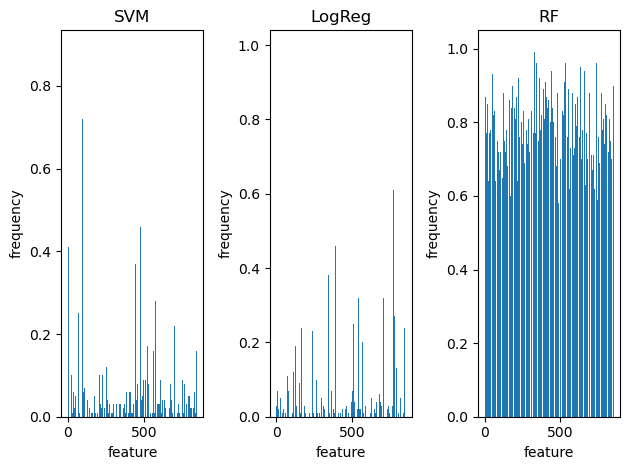

'\nthreshold = 0.7\ntop_svm = get_top_features(features, freq_dfs[0], threshold)\nprint(top_svm)\n\nmethods_top_features = get_methods_top_features(freq_df, threshold)\ntop_filter = methods_top_features[0]\ntop_select = methods_top_features[1]\ntop_sparse = methods_top_features[2]\n\ntop_shared = top_filter.intersection(top_select).union(top_filter.intersection(top_sparse)).union(top_select.intersection(top_sparse))\n\ntop_feat = {"variance filtering": top_filter, "select K best": top_select, "lasso regularization": top_sparse, "shared": top_shared}\nfor type, feat in top_feat.items():\n    print("Number of features with frequency > %s for %s: %d \n" %(threshold, type, len(feat)))\n\nthresholds = [0.5, 0.7, 0.9]\nplot_top_features(features, labels, freq_df, thresholds)\n\n# SelectKBest seems to work best when viewing the data\ntop_features_df = get_top_features(features, freq_df.iloc[0,:], threshold=0.5)\nwrite_data_file(top_features_df, \'varfilter_top50_features.csv\')\n'

In [28]:
plot_feature_frequencies(freq_dfs, titles)

"""
threshold = 0.7
top_svm = get_top_features(features, freq_dfs[0], threshold)
print(top_svm)

methods_top_features = get_methods_top_features(freq_df, threshold)
top_filter = methods_top_features[0]
top_select = methods_top_features[1]
top_sparse = methods_top_features[2]

top_shared = top_filter.intersection(top_select).union(top_filter.intersection(top_sparse)).union(top_select.intersection(top_sparse))

top_feat = {"variance filtering": top_filter, "select K best": top_select, "lasso regularization": top_sparse, "shared": top_shared}
for type, feat in top_feat.items():
    print("Number of features with frequency > %s for %s: %d \n" %(threshold, type, len(feat)))

thresholds = [0.5, 0.7, 0.9]
plot_top_features(features, labels, freq_df, thresholds)

# SelectKBest seems to work best when viewing the data
top_features_df = get_top_features(features, freq_df.iloc[0,:], threshold=0.5)
write_data_file(top_features_df, 'varfilter_top50_features.csv')
"""